# Falcons tutorial
The basic usage of Falcons is explained here. Lte's declare the use of the package as follows.

The beauty of julia is that it can leverage Python's assets.
Using `PyCall`, we can call `healpy`, and using `PyPlot` as the backend, we can use `hp.mollview` and other drawing tools as usual.
For instructions on how to install `PyCall`, see [here](https://github.com/JuliaPy/PyCall.jl).

In [1]:
using Revise
using Falcons
using PyCall
using PyPlot
hp = pyimport("healpy");

┌ Info: Precompiling Falcons [eba0fb4b-2daf-4740-90d2-e5655143e0a0]
└ @ Base loading.jl:1317
┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1317


## `ScanningStrategy` structure
Falcons has a `ScanningStrategy` structure, the internal structure of which can be seen as follows.

In [2]:
@show fieldnames(ScanningStrategy);

fieldnames(ScanningStrategy) = (:nside, :times, :sampling_rate, :alpha, :beta, :prec_period, :spin_rpm, :hwp_rpm, :FP_theta, :FP_phi, :start_point)


Next, let's input a value to the `ScanningStrategy`.
First, we declare an instance of the `ScanningStrategy` constructor as `ss`.

In [3]:
day = 60 * 60 * 24
year = day * 365

ss = ScanningStrategy()
ss.nside = 128
ss.times = year #[sec]
ss.sampling_rate = 1 #[Hz]
ss.FP_theta = [0.0] #The angle with respect to the boresight, 0 degree represents the boresight.
ss.FP_phi = [0.0]
ss.alpha = 55 #[degree]
ss.beta = 60 #[degree]
ss.prec_period = 180.22 #[sec]
ss.spin_rpm = 0.04 #[rpm]
ss.hwp_rpm = 0.05 #[rpm]
ss.start_point = "pole" #You can choose "pole" or "equator"
@show ss;

ss = ScanningStrategy(128, 31536000, 1, 55.0, 60.0, 180.22, 0.04, 0.05, AbstractFloat[0.0], AbstractFloat[0.0], "pole")


## How to calculate pointing TOD
Plot the pointing TOD drawn by the boresight from t=0 to t=10000[s].
`time_array` contains the time used in the calculation.

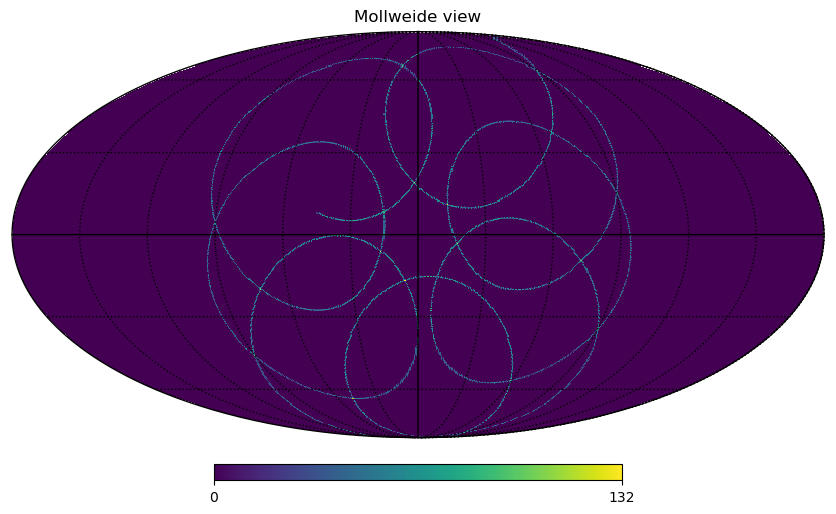

In [17]:
theta_tod, phi_tod, psi_tod, time_array = get_pointings(ss, 0, 10000)
track_map = angtod2hitmap(ss.nside, theta_tod, phi_tod)
hp.mollview(track_map, cmap="viridis")
hp.graticule()

## Mapmaking
Compute hit maps and crosslink maps according to the set scan strategy.
Specify the `devide` argument, and divide `ss.time` into four equal parts.
Since Super computer is limited in the amount of memory available, 
devide should be increased as the observation time and the number of detectors increase. However, the `devide` must be a multiple of `ss.time`.

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


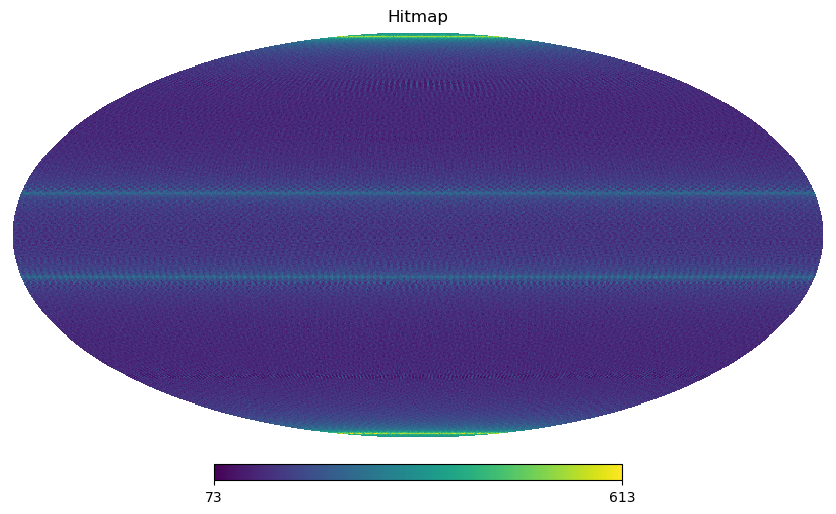

In [7]:
devide = 4
outmap = ScanningStrategy2map(ss, devide)
hp.mollview(outmap[1], title="Hitmap")

`outmap[1]` contains the result of the hitmap, as shown in the plot above.
`outmap[2]-[5]` contains the crosslink map corresponding to spin `n` as shown below.

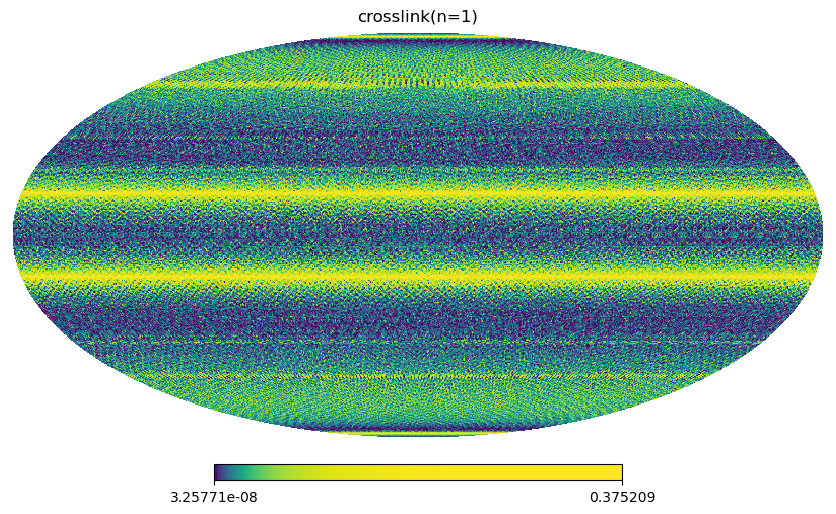

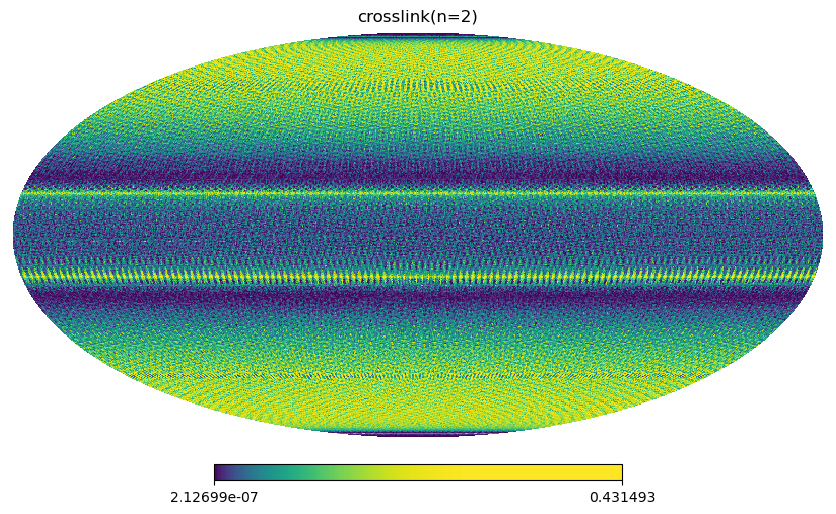

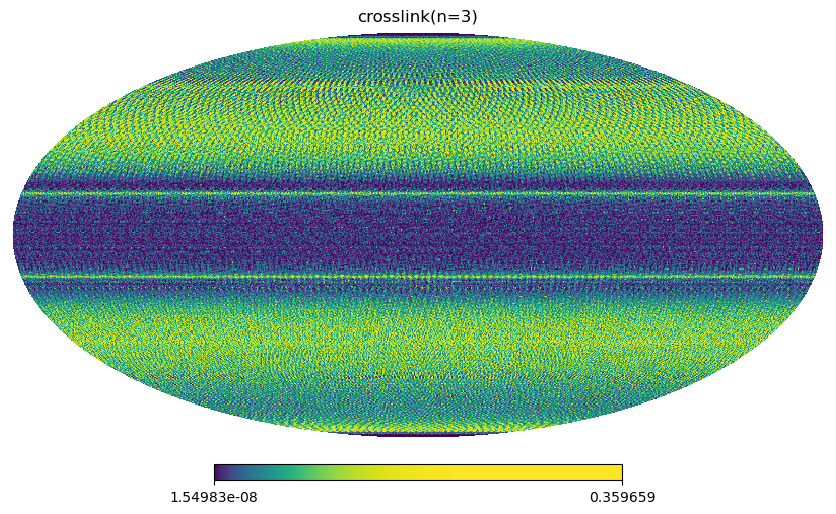

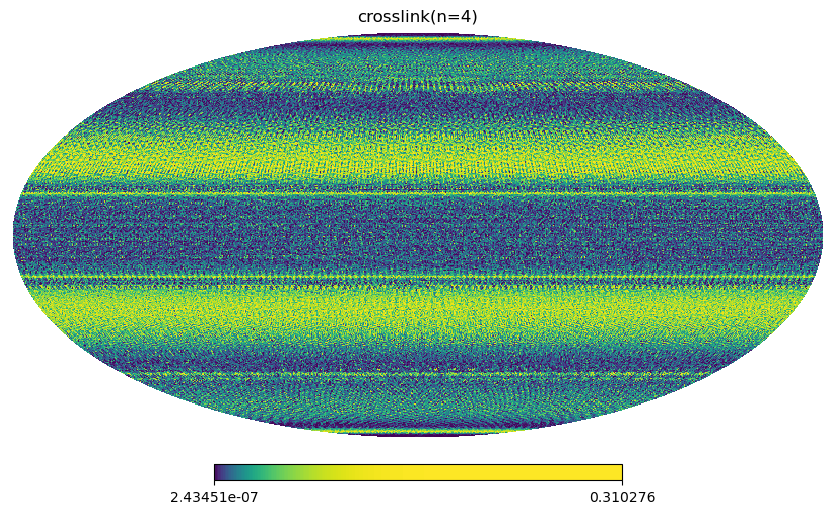

In [8]:
hp.mollview(outmap[2], title="crosslink(n=1)", norm="hist")
hp.mollview(outmap[3], title="crosslink(n=2)", norm="hist")
hp.mollview(outmap[4], title="crosslink(n=3)", norm="hist")
hp.mollview(outmap[5], title="crosslink(n=4)", norm="hist")

## Multi-channel calculations
If you want to observe more than one detector channel, just add values to the `FP_theta` and `FP_phi` arrays.
In the example below, the pointing is only 5 degrees off in the direction of $\theta$ from the boresight.
It is also possible to configure a focal plane by entering focal plane configuration.

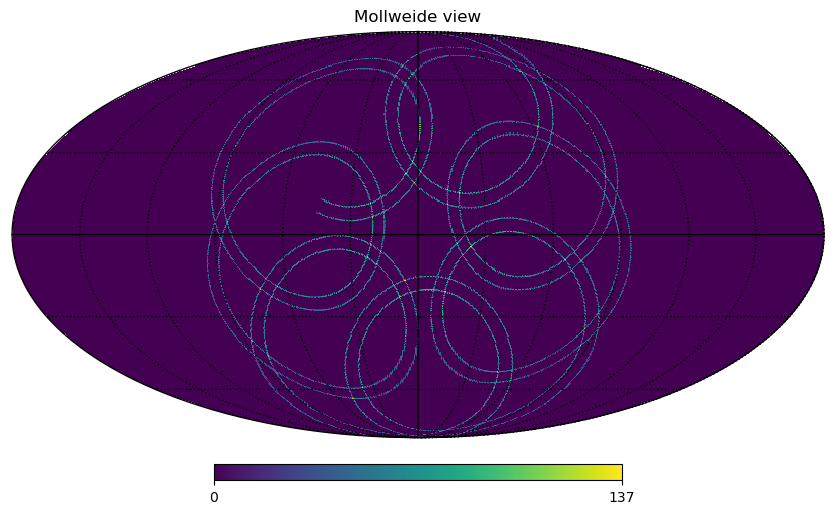

In [18]:
ss.FP_theta = [0.0, 5.0] #[1st_det, 2nd_det]
ss.FP_phi = [0.0, 0.0] #[1st_det, 2nd_det]

theta_tod, phi_tod, psi_tod, time_array = get_pointings(ss, 0, 10000)
multi_track_map = angtod2hitmap(ss.nside, theta_tod, phi_tod)
hp.mollview(multi_track_map, cmap="viridis")
hp.graticule()

## Multi-channel mapmaking
It is also possible to input a scan strategy consisting of multiple detectors into `Mapmaking`.

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


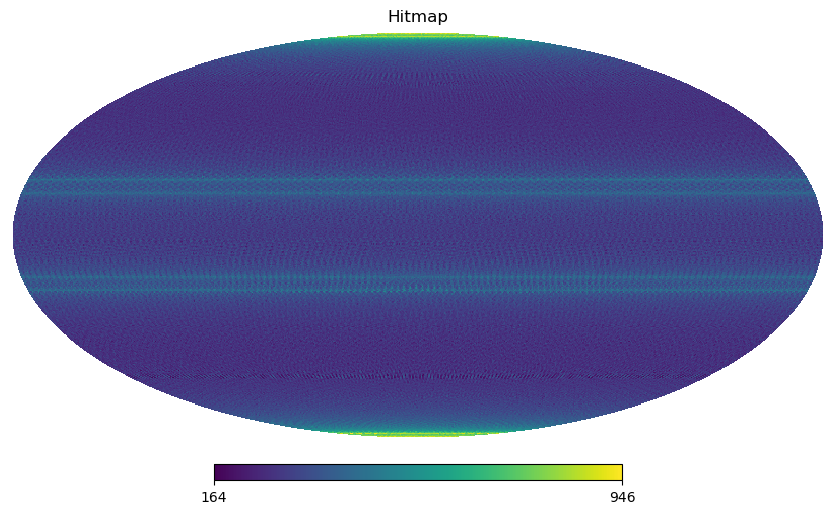

In [11]:
devide = 6
outmap = ScanningStrategy2map(ss, devide)
hp.mollview(outmap[1], title="Hitmap")

## About calculation speed
`Falcons` implements thread parallelism for pointing calculations.
Let's do the pointing calculation for one year at 19Hz.
The number of detector channels is set back to one.
Although the computation speed depends on the number of cores in the machine, the following results were obtained on KEKCC, which can run 24 threads in parallel.

In [12]:
using BenchmarkTools #If necessary, install BenchmarkTools.
ss.sampling_rate = 19 #[Hz]
ss.FP_theta = [0.0]
ss.FP_phi = [0.0]

@benchmark get_pointings(ss, 0, year)

BenchmarkTools.Trial: 
  memory estimate:  15.62 GiB
  allocs estimate:  233
  --------------
  minimum time:     21.904 s (5.57% GC)
  median time:      21.904 s (5.57% GC)
  mean time:        21.904 s (5.57% GC)
  maximum time:     21.904 s (5.57% GC)
  --------------
  samples:          1
  evals/sample:     1

This calculation is fast enough for laptops.
For example, I ran it on a local MacbookPro
processor: 2.3GHz, 4threads, Intel Core i5, RAM:16GB
It takes about 90 seconds.

Also, if you don't need the $(\theta, \phi)$ information and just want the TOD of the pixel numbers, you can use the following function.

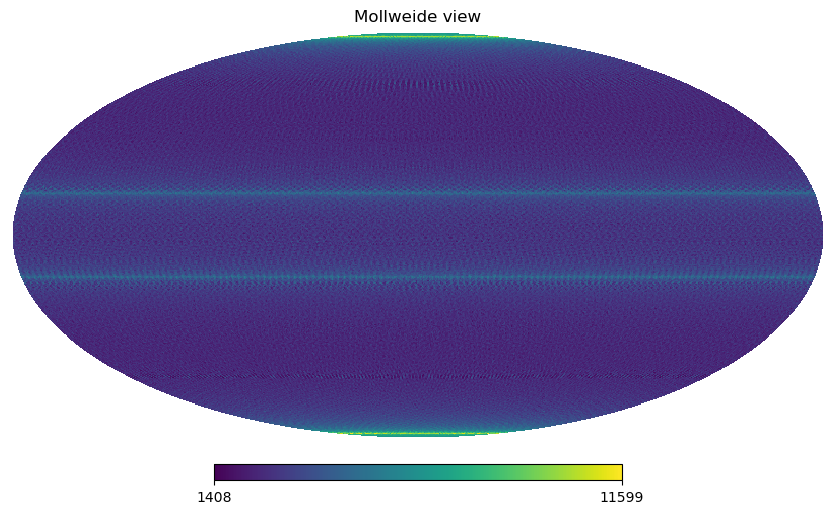

In [15]:
pix_tod, psi_tod, time_array = get_pointing_pixels(ss, 0, year)

track_map = pixtod2hitmap(ss.nside, pix_tod)
hp.mollview(track_map, cmap="viridis")

`get_pointing_pixels()` does not allocate theta and phi arrays internally, but only allocates the minimum number of arrays needed to allocate the pixel TOD.
Therefore, it runs faster than `get_pointings()`. In fact, `get_pointing_pixels()` is executed inside `ScanningStrategy2map()`.

In [16]:
@benchmark get_pointing_pixels(ss, 0, year)

BenchmarkTools.Trial: 
  memory estimate:  11.16 GiB
  allocs estimate:  222
  --------------
  minimum time:     15.169 s (0.03% GC)
  median time:      15.169 s (0.03% GC)
  mean time:        15.169 s (0.03% GC)
  maximum time:     15.169 s (0.03% GC)
  --------------
  samples:          1
  evals/sample:     1